#### 图像风格迁移

**第一步：准备内容图像和风格图像**
  
+ 读入内容图像和风格图像
+ 保持图像的长宽比，将图像尺寸resize到512

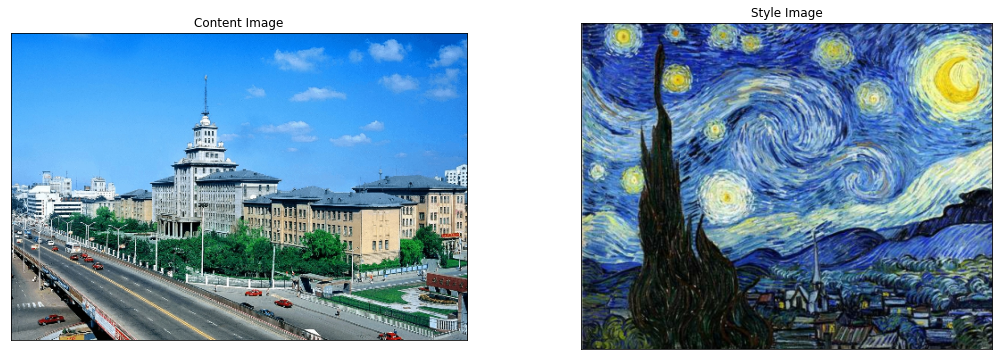

In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

max_dim = 512

content_image = tf.io.read_file(filename='HIT.jpg')
content_image = tf.image.decode_jpeg(content_image, channels=0)/255
long_dim = max(content_image.shape); 
scale = max_dim / long_dim
new_shape = tf.cast(tf.cast(content_image.shape[:-1],tf.float32)*scale,tf.int32)
content_image = tf.image.resize(content_image, new_shape)[tf.newaxis, :]

style_image = tf.io.read_file(filename='Starry Night.jpg')
style_image = tf.image.decode_jpeg(style_image, channels=0)/255
long_dim = max(style_image.shape); 
scale = max_dim / long_dim
new_shape = tf.cast(tf.cast(style_image.shape[:-1],tf.float32)*scale,tf.int32)
style_image = tf.image.resize(style_image, new_shape)[tf.newaxis, :]

fig, axes = plt.subplots(1,2,figsize=(18,6),subplot_kw={'xticks':(), 'yticks':()})
axes[0].imshow(tf.squeeze(content_image,axis=0)); axes[0].set_title('Content Image')
axes[1].imshow(tf.squeeze(style_image,axis=0)); axes[1].set_title('Style Image')

plt.show()

**第二步：借助ImageNet预学习的VGG19网络，提取图像的内容和风格信息**

+ 内容信息：在VGG19网络的block5_conv2层的输出上提取（右路）
+ 风格信息：在VGG19网络的block1_conv1，block2_conv1，block3_conv1，block4_conv1，block5_conv1上分别提取（左路）

In [45]:
#借助VGG19预学习网络，提取指定层的输出
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    
    return model

#风格信息张量的Einstein Summation
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return result/(num_locations)

#风格内容提取器，返回输入图像的风格和内容信息
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

        content_dict = {content_name:value 
                    for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
    
    
# 定义内容信息层
content_layers = ['block5_conv2'] 
num_content_layers = len(content_layers)

# 定义风格信息层
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_style_layers = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers)

#提取风格图像的风格信息（左路）
style_targets = extractor(style_image)['style']

#提取内容图像的内容信息（右路）
content_targets = extractor(content_image)['content']

**第三步：梯度法更新输入图像，迁移左路的风格信息和右路的内容信息**

+ 内容损失
    - $P$为内容图像在特定层的输出张量（block5_conv2层或block4_conv2层），$P_{ijk}$表示第$k$个通道，第$i$行，第$j$列位置的元素；(右路)
    - $F$为输入图像在特定层的输出张量（block5_conv2层或block4_conv2层），$F_{ijk}$表示第$k$个通道，第$i$行，第$j$列位置的元素；(中路)
    -定义内容损失函数：
        $$L_{content}=\frac{1}{2}\sum_{i,j,k}{(F_{ijk}-P_{ijk})^2}$$
    
+ 风格损失
    - $F^l$为输入图像在第$l$层的输出张量，$F_{ijm}^l$表示第$m$个通道，第$i$行，第$j$列位置的元素；
    - 第$l$层的输出中，第$m$个通道和第$n$个通道的相关（上一步中的gram_matrix，采用Einstein Summation实现）：
        $$ G_{mn}^l = \sum_{i,j}{F_{ijm}^l\times F_{ijn}^l} $$
    - $A^l$为风格图像计算的相应Gram Matrix；
    - 定义风格损失函数：
        $$ L_{style} = \sum_{l}{\frac{w_l}{4N_l^2M_l^2}\sum_{m,n}{(G_{mn}^l-A_{mn}^l)^2}} $$
    - $N_l$为第$l$层的通道数，$M_l$为元素个数；
    - 风格信息在style_layers中的各个层上计算；
+ 总的损失函数
    $$ L_{total} = \alpha L_{content} + \beta L_{style} $$

+ 梯度优化
    - 输入图像$\mathbf{x}$（中路）
    - 计算损失函数关于输入的梯度，学习输入图像：
        $$ \mathbf{x} \leftarrow \mathbf{x} - \eta \frac{\partial L_{total}}{\partial \mathbf{x}} $$
    

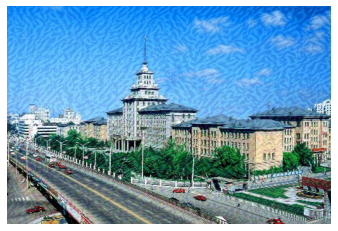

In [46]:
#设置优化器
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#剪切图像像素值到[0,1]之间
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#定义风格-内容损失函数
def style_content_loss(outputs):
    
    style_weight=1e-2
    content_weight=1e4
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

#中路输入图像梯度单步学习
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

#初始化中路输入图像为内容图像
image = tf.Variable(content_image)

#简单学习3步
train_step(image)
train_step(image)
train_step(image)

plt.imshow(tf.squeeze(image,axis=0)); plt.axis(False)
plt.show()

**完整学习**
+ 1000次迭代，每100次迭代显示一下学习结果

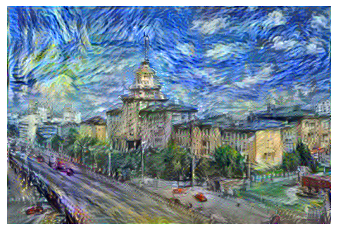

Train step: 1000
Total time: 51.4


In [47]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

#仔细学习1000步，每100步显示一次图像
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(t=plt.imshow(tf.squeeze(image,axis=0)))
    display.display(t=plt.axis(False))
    display.display(t=plt.show())
    display.display(t=print("Train step: {}".format(step)))

end = time.time()
print("Total time: {:.1f}".format(end-start))